### 经典又兼具备趣味性的Kaggle案例[泰坦尼克号问题](https://www.kaggle.com/c/titanic)
大家都熟悉的『Jack and Rose』的故事，豪华游艇倒了，大家都惊恐逃生，可是救生艇的数量有限，无法人人都有，副船长发话了『lady and kid first！』，所以是否获救其实并非随机，而是基于一些背景有rank先后的。<br>
训练和测试数据是一些乘客的个人信息以及存活状况，要尝试根据它生成合适的模型并预测其他人的存活状况。<br>
对，这是一个二分类问题，很多分类算法都可以解决。

**<font color=red>看看数据长什么样</font>**<br>
还是用pandas加载数据

In [ ]:
# 这个ipython notebook主要是我解决Kaggle Titanic问题的思路和过程

import pandas as pd #数据分析
import numpy as np #科学计算
from pandas import Series,DataFrame

data_train = pd.read_csv(r"D:\MyProj\data_analysis\data mining\Kaggle_Titanic_Example\train.csv")
data_train.columns
#data_train[data_train.Cabin.notnull()]['Survived'].value_counts()

**<font color=red>我们看大概有以下这些字段</font>**<br>
PassengerId => 乘客ID<br>
Pclass => 乘客等级(1/2/3等舱位)<br>
Name => 乘客姓名<br>
Sex => 性别<br>
Age => 年龄<br>
SibSp => 堂兄弟/妹个数<br>
Parch => 父母与小孩个数<br>
Ticket => 船票信息<br>
Fare => 票价<br>
Cabin => 客舱<br>
Embarked => 登船港口

**<font color=red>我这么懒的人显然会让pandas自己先告诉我们一些信息<font>**

In [ ]:
data_train.info()

<font color=red>上面的数据说啥了？它告诉我们，训练数据中总共有891名乘客，但是很不幸，我们有些属性的数据不全，比如说：<font><br>

* <font color=red>Age（年龄）属性只有714名乘客有记录<font>
* <font color=red>Cabin（客舱）更是只有204名乘客是已知的<font>

<font color=red>似乎信息略少啊，想再瞄一眼具体数据数值情况呢？恩，我们用下列的方法，得到数值型数据的一些分布(因为有些属性，比如姓名，是文本型；而另外一些属性，比如登船港口，是类目型。这些我们用下面的函数是看不到的)<font>

In [ ]:
data_train.describe()

<font color=red>mean字段告诉我们，大概0.383838的人最后获救了，2/3等舱的人数比1等舱要多，平均乘客年龄大概是29.7岁(计算这个时候会略掉无记录的)等等…<font>

* <font color=red>『对数据的认识太重要了！』<font>
* <font color=red>『对数据的认识太重要了！』<font>
* <font color=red>『对数据的认识太重要了！』<font>

<font color=red>口号喊完了，上面的简单描述信息并没有什么卵用啊，咱们得再细一点分析下数据啊。<font><br>
<font color=red>看看**每个/多个 属性和最后的Survived**之间有着什么样的关系<font>

In [ ]:
import matplotlib.pyplot as plt
# %matplotlib notebook
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False
plt.rcParams['figure.figsize'] = (10.0, 8.0) 
# %pylab notebook
fig = plt.figure()
fig.set(alpha=0.2,)  # 设定图表颜色alpha参数

plt.subplot2grid((2,3),(0,0))             # 在一张大图里分列几个小图
data_train.Survived.value_counts().plot(kind='bar')# plots a bar graph of those who surived vs those who did not. 
plt.title(u"获救情况 (1为获救)") # puts a title on our graph
plt.ylabel(u"人数")  

plt.subplot2grid((2,3),(0,1))
data_train.Pclass.value_counts().plot(kind="bar")
plt.ylabel(u"人数")
plt.title(u"乘客等级分布")

plt.subplot2grid((2,3),(0,2))
plt.scatter(data_train.Survived, data_train.Age)
plt.ylabel(u"年龄")                         # sets the y axis lable
plt.grid(b=True, which='major', axis='y') # formats the grid line style of our graphs
plt.title(u"按年龄看获救分布 (1为获救)")


plt.subplot2grid((2,3),(1,0), colspan=2)
data_train.Age[data_train.Pclass == 1].plot(kind='kde')   # plots a kernel desnsity estimate of the subset of the 1st class passanges's age
data_train.Age[data_train.Pclass == 2].plot(kind='kde')
data_train.Age[data_train.Pclass == 3].plot(kind='kde')
plt.xlabel(u"年龄")# plots an axis lable
plt.ylabel(u"密度") 
plt.title(u"各等级的乘客年龄分布")
plt.legend((u'头等舱', u'2等舱',u'3等舱'),loc='best') # sets our legend for our graph.


plt.subplot2grid((2,3),(1,2))
data_train.Embarked.value_counts().plot(kind='bar')
plt.title(u"各登船口岸上船人数")
plt.ylabel(u"人数")  
plt.show()


于是得到了像下面这样一张图：<br>
![](http://7xo0y8.com1.z0.glb.clouddn.com/2_titanic/8.png)

<font color=red>bingo，图还是比数字好看多了。所以我们在图上可以看出来:<font><br>
* <font color=red>被救的人300多点，不到半数；<font><br>
* <font color=red>3等舱乘客灰常多；遇难和获救的人年龄似乎跨度都很广；<font><br>
* <font color=red>3个不同的舱年龄总体趋势似乎也一致，2/3等舱乘客20岁多点的人最多，1等舱40岁左右的最多(→_→似乎符合财富和年龄的分配哈，咳咳，别理我，我瞎扯的)；<font><br>
* <font color=red>登船港口人数按照S、C、Q递减，而且S远多于另外俩港口。<font><br><br>

<font color=red>这个时候我们可能会有一些想法了：<font><br><br>

1. <font color=red>不同舱位/乘客等级可能和财富/地位有关系，最后获救概率可能会不一样<font><br>
2. <font color=red>年龄对获救概率也一定是有影响的，毕竟前面说了，副船长还说『小孩和女士先走』呢<font><br>
3. <font color=red>和登船港口是不是有关系呢？也许登船港口不同，人的出身地位不同？<font><br>

<font color=red>口说无凭，空想无益。老老实实再来统计统计，看看这些属性值的统计分布吧。<font>

In [ ]:
#看看各乘客等级的获救情况
fig = plt.figure()
fig.set(alpha=0.2)  # 设定图表颜色alpha参数

Survived_0 = data_train.Pclass[data_train.Survived == 0].value_counts()
Survived_1 = data_train.Pclass[data_train.Survived == 1].value_counts()
df=pd.DataFrame({u'获救':Survived_1, u'未获救':Survived_0})
df

In [ ]:
df.plot(kind='bar', stacked=True)
plt.title(u"各乘客等级的获救情况")
plt.xlabel(u"乘客等级") 
plt.ylabel(u"人数") 

plt.show()

In [ ]:
data_train.describe()

<font color=red>得到这个图：<font><br>
![](http://7xo0y8.com1.z0.glb.clouddn.com/2_titanic/9.png?imageView/2/w/450/q/100)

<font color=red>啧啧，果然，钱和地位对舱位有影响，进而对获救的可能性也有影响啊←_← <font><br>
<font color=red>咳咳，跑题了，我想说的是，明显等级为1的乘客，获救的概率高很多。恩，这个一定是影响最后获救结果的一个特征。<font>

In [ ]:
#看看各登录港口的获救情况
fig = plt.figure()
fig.set(alpha=0.2)  # 设定图表颜色alpha参数

Survived_0 = data_train.Embarked[data_train.Survived == 0].value_counts()
Survived_1 = data_train.Embarked[data_train.Survived == 1].value_counts()
df=pd.DataFrame({u'获救':Survived_1, u'未获救':Survived_0})
df.plot(kind='bar', stacked=True)
plt.title(u"各登录港口乘客的获救情况")
plt.xlabel(u"登录港口") 
plt.ylabel(u"人数") 

plt.show()

![](http://7xo0y8.com1.z0.glb.clouddn.com/2_titanic/Embarked.png?imageView/2/w/500/q/100)

<font color=red>并没有看出什么...<font><br>

<font color=red>那个，看看性别好了<font><br>

In [ ]:
#看看各性别的获救情况
fig = plt.figure()
fig.set(alpha=0.2)  # 设定图表颜色alpha参数

Survived_m = data_train.Survived[data_train.Sex == 'male'].value_counts()
Survived_f = data_train.Survived[data_train.Sex == 'female'].value_counts()
df=pd.DataFrame({u'男性':Survived_m, u'女性':Survived_f})
df.plot(kind='bar', stacked=True)
plt.title(u"按性别看获救情况")
plt.xlabel(u"性别") 
plt.ylabel(u"人数")
plt.show()

![](http://7xo0y8.com1.z0.glb.clouddn.com/2_titanic/10.png?imageView/2/w/450/q/100)

<font color=red>歪果盆友果然很尊重lady，lady first践行得不错。性别无疑也要作为重要特征加入最后的模型之中。<font><br>

<font color=red>再来个详细版的好了<font><br>

In [ ]:
data_train.Survived[data_train.Sex == 'female'][data_train.Pclass != 3].value_counts()

In [ ]:
data_train.Survived[data_train.Sex == 'female'][data_train.Pclass == 3].value_counts()

In [ ]:
data_train.Survived[data_train.Sex == 'male'][data_train.Pclass != 3].value_counts()

In [ ]:
count=data_train.groupby(['Pclass','Sex','Survived']).count()['PassengerId']
count

In [ ]:
pd.DataFrame(data_train.groupby(['Pclass','Sex','Survived']).count()[['PassengerId','Cabin']])

In [ ]:
#然后我们再来看看各种舱级别情况下各性别的获救情况
import numpy as np
fig=plt.figure()
fig.set(alpha=0.65) # 设置图像透明度，无所谓
plt.title(u"根据舱等级和性别的获救情况")
# plt.xticks(np.linspace(0,1000,15,endpoint=True),)
plt.xticks([],[])
ax1=fig.add_subplot(141)
data_train.Survived[data_train.Sex == 'female'][data_train.Pclass != 3].value_counts().plot(kind='bar', label="female highclass", color='#FA2479')
ax1.set_xticklabels([u"获救",u"未获救"], rotation=0)
ax1.legend([u"女性/高级舱"], loc='best')

ax2=fig.add_subplot(142, sharey=ax1)
data_train.Survived[data_train.Sex == 'female'][data_train.Pclass == 3].value_counts().plot(kind='bar', label='female, low class', color='pink')
ax2.set_xticklabels([u"未获救", u"获救"], rotation=0)
plt.legend([u"女性/低级舱"], loc='best')

ax3=fig.add_subplot(143, sharey=ax1)
data_train.Survived[data_train.Sex == 'male'][data_train.Pclass != 3].value_counts().plot(kind='bar', label='male, high class',color='lightblue')
ax3.set_xticklabels([u"未获救", u"获救"], rotation=0)
plt.legend([u"男性/高级舱"], loc='best')

ax4=fig.add_subplot(144, sharey=ax1)
data_train.Survived[data_train.Sex == 'male'][data_train.Pclass == 3].value_counts().plot(kind='bar', label='male low class', color='steelblue')
ax4.set_xticklabels([u"未获救", u"获救"], rotation=0)
plt.legend([u"男性/低级舱"], loc='best')

plt.show()

![](http://7xo0y8.com1.z0.glb.clouddn.com/2_titanic/11.png?imageView/2/w/700/q/100)

<font color=red>那堂兄弟和父母呢？<font>
<font color=red>大家族会有优势么？<font><br>

In [ ]:
g = data_train.groupby(['SibSp','Survived'])
df = pd.DataFrame(g.count()['PassengerId'])
df

In [ ]:
g = data_train.groupby(['Parch','Survived'])
df = pd.DataFrame(g.count()['PassengerId'])
df

<font color=red>好吧，没看出特别特别明显的规律(为自己的智商感到捉急…)，先作为备选特征，放一放。<font><br>
<font color=red>看看船票好了<font><br>
<font color=red>ticket是船票编号，应该是unique的，和最后的结果没有太大的关系，不纳入考虑的特征范畴<font><br>
<font color=red>cabin只有204个乘客有值，我们先看看它的一个分布<font><br>

In [ ]:
#ticket是船票编号，应该是unique的，和最后的结果没有太大的关系，不纳入考虑的特征范畴
#cabin只有204个乘客有值，我们先看看它的一个分布
data_train.Cabin.value_counts()

<font color=red>这三三两两的…如此不集中…我们猜一下，也许，前面的ABCDE是指的甲板位置、然后编号是房间号？…好吧，我瞎说的，别当真…<font><br>
<font color=red>关键是Cabin这鬼属性，应该算作类目型的，本来缺失值就多，还如此不集中，注定是个棘手货…第一感觉，这玩意儿如果直接按照类目特征处理的话，太散了，估计每个因子化后的特征都拿不到什么权重。加上有那么多缺失值，要不我们先把Cabin缺失与否作为条件(虽然这部分信息缺失可能并非未登记，maybe只是丢失了而已，所以这样做未必妥当)，先在有无Cabin信息这个粗粒度上看看Survived的情况好了。<font><br>

In [ ]:
#cabin的值计数太分散了，绝大多数Cabin值只出现一次。感觉上作为类目，加入特征未必会有效
#那我们一起看看这个值的有无，对于survival的分布状况，影响如何吧
fig = plt.figure()
fig.set(alpha=0.2)  # 设定图表颜色alpha参数

Survived_cabin = data_train.Survived[pd.notnull(data_train.Cabin)].value_counts()
Survived_nocabin = data_train.Survived[pd.isnull(data_train.Cabin)].value_counts()
df=pd.DataFrame({u'有':Survived_cabin, u'无':Survived_nocabin}).transpose()
df.plot(kind='bar', stacked=True)
plt.title(u"按Cabin有无看获救情况")
plt.xlabel(u"Cabin有无") 
plt.ylabel(u"人数")
plt.show()

#似乎有cabin记录的乘客survival比例稍高，那先试试把这个值分为两类，有cabin值/无cabin值，一会儿加到类别特征好了

![](http://7xo0y8.com1.z0.glb.clouddn.com/2_titanic/15.png?imageView/2/w/400/q/100)

<font color=red>有Cabin记录的似乎获救概率稍高一些，先这么着放一放吧。<font><br><br>

<font color=red>先从最突出的数据属性开始吧，对，Cabin和Age，有丢失数据实在是对下一步工作影响太大。<font><br>

<font color=red>先说Cabin，暂时我们就按照刚才说的，按Cabin有无数据，将这个属性处理成Yes和No两种类型吧。<font><br>

<font color=red>再说Age：<font><br>

<font color=red>通常遇到缺值的情况，我们会有几种常见的处理方式<font><br>

1. <font color=red>如果缺值的样本占总数比例极高，我们可能就直接舍弃了，作为特征加入的话，可能反倒带入noise，影响最后的结果了<font><br>
2. <font color=red>如果缺值的样本适中，而该属性非连续值特征属性(比如说类目属性)，那就把NaN作为一个新类别，加到类别特征中<font><br>
3. <font color=red>如果缺值的样本适中，而该属性为连续值特征属性，有时候我们会考虑给定一个step(比如这里的age，我们可以考虑每隔2/3岁为一个步长)，然后把它离散化，之后把NaN作为一个type加到属性类目中。<font><br>
4. <font color=red>有些情况下，缺失的值个数并不是特别多，那我们也可以试着根据已有的值，拟合一下数据，补充上。<font><br>
<font color=red>本例中，后两种处理方式应该都是可行的，我们先试试拟合补全吧(虽然说没有特别多的背景可供我们拟合，这不一定是一个多么好的选择)<font><br>

<font color=red>我们这里用scikit-learn中的RandomForest来拟合一下缺失的年龄数据<font><br>

In [ ]:
age_df = data_train[['Age','Fare', 'Parch', 'SibSp', 'Pclass']]
unknown_age=age_df[age_df.Age.isnull()].as_matrix()
unknown_age[:, 1::]

In [ ]:
from sklearn.ensemble import RandomForestRegressor
 
### 使用 RandomForestClassifier 填补缺失的年龄属性
def set_missing_ages(df):
    
    # 把已有的数值型特征取出来丢进Random Forest Regressor中
    age_df = df[['Age','Fare', 'Parch', 'SibSp', 'Pclass']]

    # 乘客分成已知年龄和未知年龄两部分
    known_age = age_df[age_df.Age.notnull()].as_matrix()
    unknown_age = age_df[age_df.Age.isnull()].as_matrix()

    # y即目标年龄
    y = known_age[:, 0]

    # X即特征属性值
    X = known_age[:, 1:]

    # fit到RandomForestRegressor之中
    rfr = RandomForestRegressor(random_state=0, n_estimators=2000, n_jobs=-1)
    rfr.fit(X, y)
    
    # 用得到的模型进行未知年龄结果预测
    predictedAges = rfr.predict(unknown_age[:, 1::])
    
    # 用得到的预测结果填补原缺失数据
    df.loc[ (df.Age.isnull()), 'Age' ] = predictedAges 
    
    return df, rfr

def set_Cabin_type(df):
    df.loc[ (df.Cabin.notnull()), 'Cabin' ] = "Yes"
    df.loc[ (df.Cabin.isnull()), 'Cabin' ] = "No"
    return df

data_train, rfr = set_missing_ages(data_train)
data_train = set_Cabin_type(data_train)
data_train

In [ ]:
data_train.info()

<font color=red>因为逻辑回归建模时，需要输入的特征都是数值型特征，我们通常会先对类目型的特征因子化/one-hot编码。 <font><br>
<font color=red>什么叫做因子化/one-hot编码？举个例子：<font><br>

<font color=red>以Embarked为例，原本一个属性维度，因为其取值可以是[‘S’,’C’,’Q‘]，而将其平展开为’Embarked_C’,’Embarked_S’, ‘Embarked_Q’三个属性<font><br>

* <font color=red>原本Embarked取值为S的，在此处的”Embarked_S”下取值为1，在’Embarked_C’, ‘Embarked_Q’下取值为0<font><br>
* <font color=red>原本Embarked取值为C的，在此处的”Embarked_C”下取值为1，在’Embarked_S’, ‘Embarked_Q’下取值为0<font><br>
* <font color=red>原本Embarked取值为Q的，在此处的”Embarked_Q”下取值为1，在’Embarked_C’, ‘Embarked_S’下取值为0<font><br>

<font color=red>我们使用pandas的”get_dummies”来完成这个工作，并拼接在原来的”data_train”之上，如下所示。<font><br>

In [ ]:
# 因为逻辑回归建模时，需要输入的特征都是数值型特征
# 我们先对类目型的特征离散/因子化
# 以Cabin为例，原本一个属性维度，因为其取值可以是['yes','no']，而将其平展开为'Cabin_yes','Cabin_no'两个属性
# 原本Cabin取值为yes的，在此处的'Cabin_yes'下取值为1，在'Cabin_no'下取值为0
# 原本Cabin取值为no的，在此处的'Cabin_yes'下取值为0，在'Cabin_no'下取值为1
# 我们使用pandas的get_dummies来完成这个工作，并拼接在原来的data_train之上，如下所示
dummies_Cabin = pd.get_dummies(data_train['Cabin'], prefix= 'Cabin')

dummies_Embarked = pd.get_dummies(data_train['Embarked'], prefix= 'Embarked')

dummies_Sex = pd.get_dummies(data_train['Sex'], prefix= 'Sex')

dummies_Pclass = pd.get_dummies(data_train['Pclass'], prefix= 'Pclass')

df = pd.concat([data_train, dummies_Cabin, dummies_Embarked, dummies_Sex, dummies_Pclass], axis=1)
df.drop(['Pclass', 'Name', 'Sex', 'Ticket', 'Cabin', 'Embarked'], axis=1, inplace=True)
df

In [ ]:
df.info()

<font color=red>我们还得做一些处理，仔细看看Age和Fare两个属性，乘客的数值幅度变化，也忒大了吧！！如果大家了解逻辑回归与梯度下降的话，会知道，各属性值之间scale差距太大，将对收敛速度造成几万点伤害值！甚至不收敛！ (╬▔皿▔)…所以我们先用scikit-learn里面的preprocessing模块对这俩货做一个scaling，所谓scaling，其实就是将一些变化幅度较大的特征化到[-1,1]之内。<font>

In [ ]:
# 接下来我们要接着做一些数据预处理的工作，比如scaling，将一些变化幅度较大的特征化到[-1,1]之内
# 这样可以加速logistic regression的收敛
import sklearn.preprocessing as preprocessing
scaler = preprocessing.StandardScaler()
age_scale_param = scaler.fit(df['Age'].values.reshape(-1,1))
df['Age_scaled'] = scaler.fit_transform(df['Age'].values.reshape(-1,1), age_scale_param)
fare_scale_param = scaler.fit(df['Fare'].values.reshape(-1,1))
df['Fare_scaled'] = scaler.fit_transform(df['Fare'].values.reshape(-1,1), fare_scale_param)
df

<font color=red>我们把需要的feature字段取出来，转成numpy格式，使用scikit-learn中的LogisticRegression建模。<font>

In [ ]:
from sklearn import linear_model

train_df = df.filter(regex='Survived|Age_.*|SibSp|Parch|Fare_.*|Cabin_.*|Embarked_.*|Sex_.*|Pclass_.*')
train_np = train_df.as_matrix()
train_np

In [ ]:
# y即Survival结果
y = train_np[:, 0]

# X即特征属性值
X = train_np[:, 1:]

# fit到RandomForestRegressor之中
clf = linear_model.LogisticRegression(C=1.0, penalty='l1', tol=1e-6)
clf.fit(X, y)
    
clf

In [ ]:
X.shape

接下来咱们对训练集和测试集做一样的操作

In [ ]:
data_test = pd.read_csv(r"D:\MyProj\data_analysis\data mining\Kaggle_Titanic_Example\test.csv",encoding='gbk')
data_test.loc[ (data_test.Fare.isnull()), 'Fare' ] = 0
# 接着我们对test_data做和train_data中一致的特征变换
# 首先用同样的RandomForestRegressor模型填上丢失的年龄
tmp_df = data_test[['Age','Fare', 'Parch', 'SibSp', 'Pclass']]
null_age = tmp_df[data_test.Age.isnull()].as_matrix()
# 根据特征属性X预测年龄并补上
X = null_age[:, 1:]
predictedAges = rfr.predict(X)
data_test.loc[ (data_test.Age.isnull()), 'Age' ] = predictedAges

data_test = set_Cabin_type(data_test)
dummies_Cabin = pd.get_dummies(data_test['Cabin'], prefix= 'Cabin')
dummies_Embarked = pd.get_dummies(data_test['Embarked'], prefix= 'Embarked')
dummies_Sex = pd.get_dummies(data_test['Sex'], prefix= 'Sex')
dummies_Pclass = pd.get_dummies(data_test['Pclass'], prefix= 'Pclass')


df_test = pd.concat([data_test, dummies_Cabin, dummies_Embarked, dummies_Sex, dummies_Pclass], axis=1)
df_test.drop(['Pclass', 'Name', 'Sex', 'Ticket', 'Cabin', 'Embarked'], axis=1, inplace=True)
df_test['Age_scaled'] = scaler.fit_transform(df_test['Age'].values.reshape(-1,1), age_scale_param)
df_test['Fare_scaled'] = scaler.fit_transform(df_test['Fare'].values.reshape(-1,1), fare_scale_param)
df_test

In [ ]:
test = df_test.filter(regex='Age_.*|SibSp|Parch|Fare_.*|Cabin_.*|Embarked_.*|Sex_.*|Pclass_.*')
test

In [ ]:

predictions = clf.predict(test)
result = pd.DataFrame({'PassengerId':data_test['PassengerId'].as_matrix(), 'Survived':predictions.astype(np.int32)})


In [ ]:
result.to_csv("logistic_regression_predictions.csv", index=False)

In [ ]:
pd.read_csv("logistic_regression_predictions.csv")

<font color=red>0.76555，恩，结果还不错。毕竟，这只是我们简单分析过后出的一个baseline系统嘛</font>

### 要判定一下当前模型所处状态(欠拟合or过拟合)

<font color=red>有一个很可能发生的问题是，我们不断地做feature engineering，产生的特征越来越多，用这些特征去训练模型，会对我们的训练集拟合得越来越好，同时也可能在逐步丧失泛化能力，从而在待预测的数据上，表现不佳，也就是发生过拟合问题。<font><br>

<font color=red>从另一个角度上说，如果模型在待预测的数据上表现不佳，除掉上面说的过拟合问题，也有可能是欠拟合问题，也就是说在训练集上，其实拟合的也不是那么好。<font><br>

<font color=red>额，这个欠拟合和过拟合怎么解释呢。这么说吧：<font><br>

1. <font color=red>过拟合就像是你班那个学数学比较刻板的同学，老师讲过的题目，一字不漏全记下来了，于是老师再出一样的题目，分分钟精确出结果。but数学考试，因为总是碰到新题目，所以成绩不咋地。<font>
2. <font color=red>欠拟合就像是，咳咳，和博主level差不多的差生。连老师讲的练习题也记不住，于是连老师出一样题目复习的周测都做不好，考试更是可想而知了。<font>

<font color=red>而在机器学习的问题上，对于过拟合和欠拟合两种情形。我们优化的方式是不同的。<font><br>

<font color=red>对过拟合而言，通常以下策略对结果优化是有用的：<font><br>

* <font color=red>做一下feature selection，挑出较好的feature的subset来做training
* <font color=red>提供更多的数据，从而弥补原始数据的bias问题，学习到的model也会更准确

<font color=red>而对于欠拟合而言，我们通常需要更多的feature，更复杂的模型来提高准确度。<font><br>

<font color=red>著名的learning curve可以帮我们判定我们的模型现在所处的状态。我们以样本数为横坐标，训练和交叉验证集上的错误率作为纵坐标，两种状态分别如下两张图所示：过拟合(overfitting/high variace)，欠拟合(underfitting/high bias)<font><br>

![](http://7xo0y8.com1.z0.glb.clouddn.com/2_titanic/high_variance.png?imageView/2/w/400/q/100)
![](http://7xo0y8.com1.z0.glb.clouddn.com/2_titanic/high_bias.png?imageView/2/w/400/q/100)

<font color=red>著名的learning curve可以帮我们判定我们的模型现在所处的状态。我们以样本数为横坐标，训练和交叉验证集上的错误率作为纵坐标，两种状态分别如下两张图所示：过拟合(overfitting/high variace)，欠拟合(underfitting/high bias)<font><br>

<font color=red>我们也可以把错误率替换成准确率(得分)，得到另一种形式的learning curve(sklearn 里面是这么做的)。<font><br>

<font color=red>回到我们的问题，我们用scikit-learn里面的learning_curve来帮我们分辨我们模型的状态。举个例子，这里我们一起画一下我们最先得到的baseline model的learning curve。<font><br>

In [ ]:
X.shape

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.learning_curve import learning_curve

# 用sklearn的learning_curve得到training_score和cv_score，使用matplotlib画出learning curve
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=1, 
                        train_sizes=np.linspace(.05, 1., 20), verbose=0, plot=True):
    """
    画出data在某模型上的learning curve.
    参数解释
    ----------
    estimator : 你用的分类器。
    title : 表格的标题。
    X : 输入的feature，numpy类型
    y : 输入的target vector
    ylim : tuple格式的(ymin, ymax), 设定图像中纵坐标的最低点和最高点
    cv : 做cross-validation的时候，数据分成的份数，其中一份作为cv集，其余n-1份作为training(默认为3份)
    n_jobs : 并行的的任务数(默认1)
    """
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, verbose=verbose)
    print(train_sizes)
    print(train_scores)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    if plot:
        plt.figure()
        plt.title(title)
        if ylim is not None:
            plt.ylim(*ylim)
        plt.xlabel(u"训练样本数")
        plt.ylabel(u"得分")
        plt.gca().invert_yaxis()
        plt.grid()
    
        plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, 
                         alpha=0.1, color="b")
        plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, 
                         alpha=0.1, color="r")
        plt.plot(train_sizes, train_scores_mean, 'o-', color="b", label=u"训练集上得分")
        plt.plot(train_sizes, test_scores_mean, 'o-', color="r", label=u"交叉验证集上得分")
    
        plt.legend(loc="best")
        
        plt.draw()
        plt.gca().invert_yaxis()
        plt.show()
    
    midpoint = ((train_scores_mean[-1] + train_scores_std[-1]) + (test_scores_mean[-1] - test_scores_std[-1])) / 2
    diff = (train_scores_mean[-1] + train_scores_std[-1]) - (test_scores_mean[-1] - test_scores_std[-1])
    return midpoint, diff

plot_learning_curve(clf, u"学习曲线", X, y)

![](http://7xo0y8.com1.z0.glb.clouddn.com/2_titanic/learning_curve.png?imageView/2/w/600/q/100)
<font color=red>在实际数据上看，我们得到的learning curve没有理论推导的那么光滑哈，但是可以大致看出来，训练集和交叉验证集上的得分曲线走势还是符合预期的。<font><br>

<font color=red>目前的曲线看来，我们的model并不处于overfitting的状态(overfitting的表现一般是训练集上得分高，而交叉验证集上要低很多，中间的gap比较大)。因此我们可以再做些feature engineering的工作，添加一些新产出的特征或者组合特征到模型中。<font><br>

<font color=red>接下来，我们就该看看如何优化baseline系统了<br>
我们还有些特征可以再挖掘挖掘<br><br>

1. 比如说Name和Ticket两个属性被我们完整舍弃了(好吧，其实是一开始我们对于这种，每一条记录都是一个完全不同的值的属性，并没有很直接的处理方式)<br>
2. 比如说，我们想想，年龄的拟合本身也未必是一件非常靠谱的事情<br>
3. 另外，以我们的日常经验，小盆友和老人可能得到的照顾会多一些，这样看的话，年龄作为一个连续值，给一个固定的系数，似乎体现不出两头受照顾的实际情况，所以，说不定我们把年龄离散化，按区段分作类别属性会更合适一些<br>

那怎么样才知道，哪些地方可以优化，哪些优化的方法是promising的呢？<br>
是的<br><br>

要做交叉验证(cross validation)!<br>
要做交叉验证(cross validation)!<br>
要做交叉验证(cross validation)!<br><br>

重要的事情说3编！！！<br>
因为test.csv里面并没有Survived这个字段(好吧，这是废话，这明明就是我们要预测的结果)，我们无法在这份数据上评定我们算法在该场景下的效果。。。<br>
我们通常情况下，这么做cross validation：把train.csv分成两部分，一部分用于训练我们需要的模型，另外一部分数据上看我们预测算法的效果。<br>
我们可以用scikit-learn的cross_validation来完成这个工作</font>

In [ ]:
list(train_df.columns)[1:]

In [ ]:
list(clf.coef_.T)

<font color=red>在此之前，咱们可以看看现在得到的模型的系数，因为系数和它们最终的判定能力强弱是正相关的</font>

In [ ]:
pd.DataFrame({"columns":list(train_df.columns)[1:], "coef":list(clf.coef_.T)})

上面的系数和最后的结果是一个正相关的关系<br>
我们先看看那些权重绝对值非常大的feature，在我们的模型上：<br>

* Sex属性，如果是female会极大提高最后获救的概率，而male会很大程度拉低这个概率。
* Pclass属性，1等舱乘客最后获救的概率会上升，而乘客等级为3会极大地拉低这个概率。
* 有Cabin值会很大程度拉升最后获救概率(这里似乎能看到了一点端倪，事实上从最上面的有无Cabin记录的Survived分布图上看出，即使有Cabin记录的乘客也有一部分遇难了，估计这个属性上我们挖掘还不够)
* Age是一个负相关，意味着在我们的模型里，年龄越小，越有获救的优先权(还得回原数据看看这个是否合理）
* 有一个登船港口S会很大程度拉低获救的概率，另外俩港口压根就没啥作用(这个实际上非常奇怪，因为我们从之前的统计图上并没有看到S港口的获救率非常低，所以也许可以考虑把登船港口这个feature去掉试试)。
* 船票Fare有小幅度的正相关(并不意味着这个feature作用不大，有可能是我们细化的程度还不够，举个例子，说不定我们得对它离散化，再分至各个乘客等级上？)

噢啦，观察完了，我们现在有一些想法了，但是怎么样才知道，哪些优化的方法是promising的呢？<br>

恩，要靠交叉验证

In [ ]:
df

In [ ]:
from sklearn import cross_validation

# 简单看看打分情况
clf = linear_model.LogisticRegression(C=1.0, penalty='l1', tol=1e-6)
all_data = df.filter(regex='Survived|Age_.*|SibSp|Parch|Fare_.*|Cabin_.*|Embarked_.*|Sex_.*|Pclass_.*')
X = all_data.as_matrix()[:,1:]
y = all_data.as_matrix()[:,0]
print(cross_validation.cross_val_score(clf, X, y, cv=5))


# 分割数据
split_train, split_cv = cross_validation.train_test_split(df, test_size=0.3, random_state=0)
train_df = split_train.filter(regex='Survived|Age_.*|SibSp|Parch|Fare_.*|Cabin_.*|Embarked_.*|Sex_.*|Pclass_.*')
# 生成模型
clf = linear_model.LogisticRegression(C=1.0, penalty='l1', tol=1e-6)
clf.fit(train_df.as_matrix()[:,1:], train_df.as_matrix()[:,0])



# 对cross validation数据进行预测

cv_df = split_cv.filter(regex='Survived|Age_.*|SibSp|Parch|Fare_.*|Cabin_.*|Embarked_.*|Sex_.*|Pclass_.*')
predictions = clf.predict(cv_df.as_matrix()[:,1:])
split_cv[ predictions != cv_df.as_matrix()[:,0] ].sort_values('PassengerId')

In [ ]:
# 去除预测错误的case看原始dataframe数据
#split_cv['PredictResult'] = predictions
origin_data_train = pd.read_csv(r"D:\MyProj\data_analysis\data mining\Kaggle_Titanic_Example\train.csv")
bad_cases = origin_data_train.loc[origin_data_train['PassengerId'].isin(split_cv[predictions != cv_df.as_matrix()[:,0]]['PassengerId'].values)]
bad_cases

对比bad case，我们仔细看看我们预测错的样本，到底是哪些特征有问题，咱们处理得还不够细？<br>

我们随便列一些可能可以做的优化操作：<br>

* Age属性不使用现在的拟合方式，而是根据名称中的『Mr』『Mrs』『Miss』等的平均值进行填充。
* Age不做成一个连续值属性，而是使用一个步长进行离散化，变成离散的类目feature。
* Cabin再细化一些，对于有记录的Cabin属性，我们将其分为前面的字母部分(我猜是位置和船层之类的信息) 和 后面的数字部分(应该是房间号，有意思的事情是，如果你仔细看看原始数据，你会发现，这个值大的情况下，似乎获救的可能性高一些)。
* Pclass和Sex俩太重要了，我们试着用它们去组出一个组合属性来试试，这也是另外一种程度的细化。
* 单加一个Child字段，Age<=12的，设为1，其余为0(你去看看数据，确实小盆友优先程度很高啊)
* 如果名字里面有『Mrs』，而Parch>1的，我们猜测她可能是一个母亲，应该获救的概率也会提高，因此可以多加一个Mother字段，此种情况下设为1，其余情况下设为0
* 登船港口可以考虑先去掉试试(Q和C本来就没权重，S有点诡异)
* 把堂兄弟/兄妹 和 Parch 还有自己 个数加在一起组一个Family_size字段(考虑到大家族可能对最后的结果有影响)
* Name是一个我们一直没有触碰的属性，我们可以做一些简单的处理，比如说男性中带某些字眼的(‘Capt’, ‘Don’, ‘Major’, ‘Sir’)可以统一到一个Title，女性也一样。

大家接着往下挖掘，可能还可以想到更多可以细挖的部分。我这里先列这些了，然后我们可以使用手头上的”train_df”和”cv_df”开始试验这些feature engineering的tricks是否有效了。

In [ ]:
data_train[data_train['Name'].str.contains("Major")]

In [1]:
import pandas as pd #数据分析
import numpy as np #科学计算
from pandas import Series,DataFrame

In [2]:
data_train = pd.read_csv(r"D:\MyProj\data_analysis\data mining\Kaggle_Titanic_Example\train.csv")
data_train['Sex_Pclass'] = data_train.Sex + "_" + data_train.Pclass.map(str)
data_train['Special_Person']=0
data_train['Mother']=0
data_train['Mother'][(data_train.Sex=='female')&(data_train.Parch==1)]=1
data_train['Family']=data_train.Parch+data_train.SibSp
data_train

D:\APP\anaconda\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex_Pclass,Special_Person,Mother,Family
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,male_3,0,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,female_1,0,0,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,female_3,0,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,female_1,0,0,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,male_3,0,0,0
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q,male_3,0,0,0
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S,male_1,0,0,0
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S,male_3,0,0,4
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S,female_3,0,0,2
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C,female_2,0,0,1


In [3]:


from sklearn.ensemble import RandomForestRegressor
 
### 使用 RandomForestClassifier 填补缺失的年龄属性
def set_missing_ages(df):
    
    # 把已有的数值型特征取出来丢进Random Forest Regressor中
    age_df = df[['Age','Fare', 'Parch', 'SibSp', 'Pclass']]

    # 乘客分成已知年龄和未知年龄两部分
    known_age = age_df[age_df.Age.notnull()].as_matrix()
    unknown_age = age_df[age_df.Age.isnull()].as_matrix()

    # y即目标年龄
    y = known_age[:, 0]

    # X即特征属性值
    X = known_age[:, 1:]

    # fit到RandomForestRegressor之中
    rfr = RandomForestRegressor(random_state=0, n_estimators=2000, n_jobs=-1)
    rfr.fit(X, y)
    
    # 用得到的模型进行未知年龄结果预测
    predictedAges = rfr.predict(unknown_age[:, 1::])
    
    # 用得到的预测结果填补原缺失数据
    df.loc[ (df.Age.isnull()), 'Age' ] = predictedAges 
    
    return df, rfr

def set_Cabin_type(df):
    df.loc[ (df.Cabin.notnull()), 'Cabin' ] = "Yes"
    df.loc[ (df.Cabin.isnull()), 'Cabin' ] = "No"
    return df

data_train, rfr = set_missing_ages(data_train)
data_train = set_Cabin_type(data_train)
data_train.Special_Person[(data_train['Age'] <= 12)|(data_train['Age'] >= 55)]=1
dummies_Cabin = pd.get_dummies(data_train['Cabin'], prefix= 'Cabin')
dummies_Embarked = pd.get_dummies(data_train['Embarked'], prefix= 'Embarked')
dummies_Sex = pd.get_dummies(data_train['Sex'], prefix= 'Sex')
dummies_Pclass = pd.get_dummies(data_train['Pclass'], prefix= 'Pclass')
dummies_Sex_Pclass = pd.get_dummies(data_train['Sex_Pclass'], prefix= 'Sex_Pclass')
dummies_Special_Person = pd.get_dummies(data_train['Special_Person'], prefix= 'Special_Person')
dummies_Mother = pd.get_dummies(data_train['Mother'], prefix= 'Mother')
df = pd.concat([data_train, dummies_Cabin, dummies_Embarked, dummies_Sex, dummies_Pclass, dummies_Sex_Pclass,dummies_Special_Person,dummies_Mother \
               ], axis=1)
df.drop(['Pclass', 'Name', 'Sex', 'Ticket', 'Cabin', 'Embarked', 'Sex_Pclass','Special_Person','Mother'], axis=1, inplace=True)
df.head(10)

D:\APP\anaconda\lib\site-packages\ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,PassengerId,Survived,Age,SibSp,Parch,Fare,Family,Cabin_No,Cabin_Yes,Embarked_C,...,Sex_Pclass_female_1,Sex_Pclass_female_2,Sex_Pclass_female_3,Sex_Pclass_male_1,Sex_Pclass_male_2,Sex_Pclass_male_3,Special_Person_0,Special_Person_1,Mother_0,Mother_1
0,1,0,22.000000,1,0,7.2500,1,1,0,0,...,0,0,0,0,0,1,1,0,1,0
1,2,1,38.000000,1,0,71.2833,1,0,1,1,...,1,0,0,0,0,0,1,0,1,0
2,3,1,26.000000,0,0,7.9250,0,1,0,0,...,0,0,1,0,0,0,1,0,1,0
3,4,1,35.000000,1,0,53.1000,1,0,1,0,...,1,0,0,0,0,0,1,0,1,0
4,5,0,35.000000,0,0,8.0500,0,1,0,0,...,0,0,0,0,0,1,1,0,1,0
5,6,0,23.838953,0,0,8.4583,0,1,0,0,...,0,0,0,0,0,1,1,0,1,0
6,7,0,54.000000,0,0,51.8625,0,0,1,0,...,0,0,0,1,0,0,1,0,1,0
7,8,0,2.000000,3,1,21.0750,4,1,0,0,...,0,0,0,0,0,1,0,1,1,0
8,9,1,27.000000,0,2,11.1333,2,1,0,0,...,0,0,1,0,0,0,1,0,1,0
9,10,1,14.000000,1,0,30.0708,1,1,0,1,...,0,1,0,0,0,0,1,0,1,0


In [4]:
import sklearn.preprocessing as preprocessing
scaler = preprocessing.StandardScaler()
age_scale_param = scaler.fit(df['Age'].values.reshape(-1,1))
df['Age_scaled'] = scaler.fit_transform(df['Age'].values.reshape(-1,1), age_scale_param)
fare_scale_param = scaler.fit(df['Fare'].values.reshape(-1,1))
df['Fare_scaled'] = scaler.fit_transform(df['Fare'].values.reshape(-1,1), fare_scale_param)
df.head(10)

,PassengerId,Survived,Age,SibSp,Parch,Fare,Family,Cabin_No,Cabin_Yes,Embarked_C,...,Sex_Pclass_female_3,Sex_Pclass_male_1,Sex_Pclass_male_2,Sex_Pclass_male_3,Special_Person_0,Special_Person_1,Mother_0,Mother_1,Age_scaled,Fare_scaled
0,1,0,22.000000,1,0,7.2500,1,1,0,0,...,0,0,0,1,1,0,1,0,-0.561380,-0.502445
1,2,1,38.000000,1,0,71.2833,1,0,1,1,...,0,0,0,0,1,0,1,0,0.613171,0.786845
2,3,1,26.000000,0,0,7.9250,0,1,0,0,...,1,0,0,0,1,0,1,0,-0.267742,-0.488854
3,4,1,35.000000,1,0,53.1000,1,0,1,0,...,0,0,0,0,1,0,1,0,0.392942,0.420730
4,5,0,35.000000,0,0,8.0500,0,1,0,0,...,0,0,0,1,1,0,1,0,0.392942,-0.486337
5,6,0,23.838953,0,0,8.4583,0,1,0,0,...,0,0,0,1,1,0,1,0,-0.426384,-0.478116
6,7,0,54.000000,0,0,51.8625,0,0,1,0,...,0,1,0,0,1,0,1,0,1.787722,0.395814
7,8,0,2.000000,3,1,21.0750,4,1,0,0,...,0,0,0,1,0,1,1,0,-2.029569,-0.224083
8,9,1,27.000000,0,2,11.1333,2,1,0,0,...,1,0,0,0,1,0,1,0,-0.194333,-0.424256
9,10,1,14.000000,1,0,30.0708,1,1,0,1,...,0,0,0,0,1,0,1,0,-1.148655,-0.042956


In [5]:

from sklearn import linear_model

train_df = df.filter(regex='Survived|Age_.*|SibSp|Parch|Fare_.*|Cabin_.*|Embarked_.*|Sex_.*|Pclass_.*|Special_.*|Family|Mother_.*')
train_np = train_df.as_matrix()
train_np.shape

(891, 26)

In [6]:
# y即Survival结果
y = train_np[:, 0]
# X即特征属性值
X = train_np[:, 1:]
# fit到RandomForestRegressor之中
clf = linear_model.LogisticRegression(C=1.0, penalty='l1', tol=1e-6)
clf.fit(X, y)
clf

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=1e-06,
          verbose=0, warm_start=False)

D:\APP\anaconda\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
D:\APP\anaconda\lib\site-packages\sklearn\learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


[ 29  59  89 118 148 178 207 237 267 296 326 356 386 415 445 475 504 534
 564 594]
[[ 0.89655172  0.86206897  0.86206897]
 [ 0.89830508  0.89830508  0.89830508]
 [ 0.88764045  0.84269663  0.84269663]
 [ 0.83898305  0.8559322   0.8559322 ]
 [ 0.85135135  0.82432432  0.82432432]
 [ 0.8258427   0.84831461  0.84831461]
 [ 0.82125604  0.83574879  0.83574879]
 [ 0.82278481  0.82700422  0.82700422]
 [ 0.83146067  0.82771536  0.82771536]
 [ 0.8277027   0.81418919  0.82094595]
 [ 0.82822086  0.80368098  0.82515337]
 [ 0.8258427   0.80898876  0.82303371]
 [ 0.82901554  0.80569948  0.83160622]
 [ 0.82650602  0.80240964  0.8313253 ]
 [ 0.83820225  0.81573034  0.8247191 ]
 [ 0.82315789  0.81263158  0.81894737]
 [ 0.8234127   0.8015873   0.8234127 ]
 [ 0.82209738  0.8071161   0.82209738]
 [ 0.82092199  0.81205674  0.82446809]
 [ 0.82491582  0.81144781  0.83333333]]


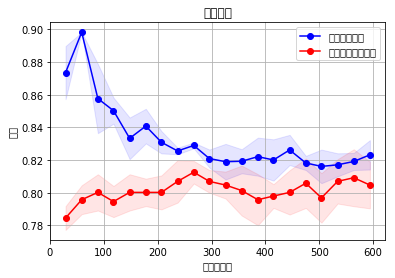

(0.81133741141456039, 0.041817184358543646)

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.learning_curve import learning_curve

# 用sklearn的learning_curve得到training_score和cv_score，使用matplotlib画出learning curve
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=1, 
                        train_sizes=np.linspace(.05, 1., 20), verbose=0, plot=True):
    """
    画出data在某模型上的learning curve.
    参数解释
    ----------
    estimator : 你用的分类器。
    title : 表格的标题。
    X : 输入的feature，numpy类型
    y : 输入的target vector
    ylim : tuple格式的(ymin, ymax), 设定图像中纵坐标的最低点和最高点
    cv : 做cross-validation的时候，数据分成的份数，其中一份作为cv集，其余n-1份作为training(默认为3份)
    n_jobs : 并行的的任务数(默认1)
    """
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, verbose=verbose)
    print(train_sizes)
    print(train_scores)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    if plot:
        plt.figure()
        plt.title(title)
        if ylim is not None:
            plt.ylim(*ylim)
        plt.xlabel(u"训练样本数")
        plt.ylabel(u"得分")
        plt.gca().invert_yaxis()
        plt.grid()
    
        plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, 
                         alpha=0.1, color="b")
        plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, 
                         alpha=0.1, color="r")
        plt.plot(train_sizes, train_scores_mean, 'o-', color="b", label=u"训练集上得分")
        plt.plot(train_sizes, test_scores_mean, 'o-', color="r", label=u"交叉验证集上得分")
    
        plt.legend(loc="best")
        
        plt.draw()
        plt.gca().invert_yaxis()
        plt.show()
    
    midpoint = ((train_scores_mean[-1] + train_scores_std[-1]) + (test_scores_mean[-1] - test_scores_std[-1])) / 2
    diff = (train_scores_mean[-1] + train_scores_std[-1]) - (test_scores_mean[-1] - test_scores_std[-1])
    return midpoint, diff

plot_learning_curve(clf, u"学习曲线", X, y)

In [32]:
data_test = pd.read_csv(r"D:\MyProj\data_analysis\data mining\Kaggle_Titanic_Example\test.csv")
data_test.loc[ (data_test.Fare.isnull()), 'Fare' ] = 0
data_test['Sex_Pclass'] = data_test.Sex + "_" + data_test.Pclass.map(str)
data_test['Special_Person']=0
data_test['Mother']=0
data_test['Mother'][(data_test.Sex=='female')&(data_test.Parch==1)]=1
data_test['Family']=data_test.Parch+data_test.SibSp

# 接着我们对test_data做和train_data中一致的特征变换
# 首先用同样的RandomForestRegressor模型填上丢失的年龄
tmp_df = data_test[['Age','Fare', 'Parch', 'SibSp', 'Pclass']]
null_age = tmp_df[data_test.Age.isnull()].as_matrix()
# 根据特征属性X预测年龄并补上
X = null_age[:, 1:]
predictedAges = rfr.predict(X)
data_test.loc[ (data_test.Age.isnull()), 'Age' ] = predictedAges
data_test.Special_Person[(data_test['Age'] <= 12)|(data_test['Age'] >= 55)]=1
data_test = set_Cabin_type(data_test)
dummies_Cabin = pd.get_dummies(data_test['Cabin'], prefix= 'Cabin')
dummies_Embarked = pd.get_dummies(data_test['Embarked'], prefix= 'Embarked')
dummies_Sex = pd.get_dummies(data_test['Sex'], prefix= 'Sex')
dummies_Pclass = pd.get_dummies(data_test['Pclass'], prefix= 'Pclass')
dummies_Sex_Pclass = pd.get_dummies(data_test['Sex_Pclass'], prefix= 'Sex_Pclass')
dummies_Special_Person = pd.get_dummies(data_test['Special_Person'], prefix= 'Special_Person')
dummies_Mother = pd.get_dummies(data_test['Mother'], prefix= 'Mother')

df_test = pd.concat([data_test, dummies_Cabin, dummies_Embarked, dummies_Sex, dummies_Pclass, dummies_Sex_Pclass,dummies_Special_Person \
                    ,dummies_Mother], axis=1)
df_test.drop(['Pclass', 'Name', 'Sex', 'Ticket', 'Cabin', 'Embarked', 'Sex_Pclass','Special_Person','Mother'], axis=1, inplace=True)
df_test['Age_scaled'] = scaler.fit_transform(df_test['Age'].values.reshape(-1,1), age_scale_param)
df_test['Fare_scaled'] = scaler.fit_transform(df_test['Fare'].values.reshape(-1,1), fare_scale_param)
df_test.head(10)

D:\APP\anaconda\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
D:\APP\anaconda\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,PassengerId,Age,SibSp,Parch,Fare,Family,Cabin_No,Cabin_Yes,Embarked_C,Embarked_Q,...,Sex_Pclass_female_3,Sex_Pclass_male_1,Sex_Pclass_male_2,Sex_Pclass_male_3,Special_Person_0,Special_Person_1,Mother_0,Mother_1,Age_scaled,Fare_scaled
0,892,34.5,0,0,7.8292,0,1,0,0,1,...,0,0,0,1,1,0,1,0,0.307521,-0.496637
1,893,47.0,1,0,7.0000,1,1,0,0,0,...,1,0,0,0,1,0,1,0,1.256241,-0.511497
2,894,62.0,0,0,9.6875,0,1,0,0,1,...,0,0,1,0,0,1,1,0,2.394706,-0.463335
3,895,27.0,0,0,8.6625,0,1,0,0,0,...,0,0,0,1,1,0,1,0,-0.261711,-0.481704
4,896,22.0,1,1,12.2875,2,1,0,0,0,...,1,0,0,0,1,0,0,1,-0.641199,-0.416740
5,897,14.0,0,0,9.2250,0,1,0,0,0,...,0,0,0,1,1,0,1,0,-1.248380,-0.471623
6,898,30.0,0,0,7.6292,0,1,0,0,1,...,1,0,0,0,1,0,1,0,-0.034018,-0.500221
7,899,26.0,1,1,29.0000,2,1,0,0,0,...,0,0,1,0,1,0,1,0,-0.337609,-0.117238
8,900,18.0,0,0,7.2292,0,1,0,1,0,...,1,0,0,0,1,0,1,0,-0.944790,-0.507390
9,901,21.0,2,0,24.1500,2,1,0,0,0,...,0,0,0,1,1,0,1,0,-0.717097,-0.204154


In [ ]:
test = df_test.filter(regex='Age_.*|SibSp|Parch|Fare_.*|Cabin_.*|Embarked_.*|Sex_.*|Pclass.*')
predictions = clf.predict(test)
result = pd.DataFrame({'PassengerId':data_test['PassengerId'].as_matrix(), 'Survived':predictions.astype(np.int32)})
result.to_csv("logistic_regression_predictions2.csv", index=False)

<font color=red>一般做到后期，咱们要进行模型优化的方法就是模型融合啦<br>
先解释解释啥叫模型融合哈，我们还是举几个例子直观理解一下好了。<br><br>

大家都看过知识问答的综艺节目中，求助现场观众时候，让观众投票，最高的答案作为自己的答案的形式吧，每个人都有一个判定结果，最后我们相信答案在大多数人手里。<br>

再通俗一点举个例子。你和你班某数学大神关系好，每次作业都『模仿』他的，于是绝大多数情况下，他做对了，你也对了。突然某一天大神脑子犯糊涂，手一抖，写错了一个数，于是…恩，你也只能跟着错了。 <br>
我们再来看看另外一个场景，你和你班5个数学大神关系都很好，每次都把他们作业拿过来，对比一下，再『自己做』，那你想想，如果哪天某大神犯糊涂了，写错了，but另外四个写对了啊，那你肯定相信另外4人的是正确答案吧？<br>

最简单的模型融合大概就是这么个意思，比如分类问题，当我们手头上有一堆在同一份数据集上训练得到的分类器(比如logistic regression，SVM，KNN，random forest，神经网络)，那我们让他们都分别去做判定，然后对结果做投票统计，取票数最多的结果为最后结果。<br>

bingo，问题就这么完美的解决了。<br>

模型融合可以比较好地缓解，训练过程中产生的过拟合问题，从而对于结果的准确度提升有一定的帮助。<br>

话说回来，回到我们现在的问题。你看，我们现在只讲了logistic regression，如果我们还想用这个融合思想去提高我们的结果，我们该怎么做呢？<br>

既然这个时候模型没得选，那咱们就在数据上动动手脚咯。大家想想，如果模型出现过拟合现在，一定是在我们的训练上出现拟合过度造成的对吧。<br>

那我们干脆就不要用全部的训练集，每次取训练集的一个subset，做训练，这样，我们虽然用的是同一个机器学习算法，但是得到的模型却是不一样的；同时，因为我们没有任何一份子数据集是全的，因此即使出现过拟合，也是在子训练集上出现过拟合，而不是全体数据上，这样做一个融合，可能对最后的结果有一定的帮助。对，这就是常用的Bagging。<br>

我们用scikit-learn里面的Bagging来完成上面的思路，过程非常简单。代码如下：<br><br><font>

In [18]:
from sklearn.ensemble import BaggingRegressor

train_df = df.filter(regex='Survived|Age_.*|SibSp|Parch|Fare_.*|Cabin_.*|Embarked_.*|Sex_.*|Pclass.*|Mother.*|Special_.*|Family')
train_np = train_df.as_matrix()
train_np.shape

(891, 26)

In [34]:
# y即Survival结果
y = train_np[:, 0]
# X即特征属性值
X = train_np[:, 1:]
# fit到BaggingRegressor之中
clf = linear_model.LogisticRegression(C=1.0, penalty='l1', tol=1e-6)
bagging_clf = BaggingRegressor(clf, n_estimators=10, max_samples=0.8, max_features=1.0, bootstrap=True, bootstrap_features=False, n_jobs=-1)
bagging_clf.fit(X, y)

test = df_test.filter(regex='Age_.*|SibSp|Parch|Fare_.*|Cabin_.*|Embarked_.*|Sex_.*|Pclass.*|Mother.*|Special_.*|Family')
predictions = bagging_clf.predict(test)
predictions
result = pd.DataFrame({'PassengerId':data_test['PassengerId'].as_matrix(), 'Survived':predictions.astype(np.int32)})
result.to_csv("logistic_regression_predictions3.csv", index=False)

<font color=red>下面是咱们用别的分类器解决这个问题的代码：</font>

In [ ]:
import numpy as np
import pandas as pd
from pandas import  DataFrame
from patsy import dmatrices
import string
from operator import itemgetter
import json
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split,StratifiedShuffleSplit,StratifiedKFold
from sklearn import preprocessing
from sklearn.metrics import classification_report
from sklearn.externals import joblib

##Read configuration parameters

train_file="train.csv"
MODEL_PATH="./"
test_file="test.csv"
SUBMISSION_PATH="./"
seed= 0

print train_file,seed

# 输出得分
def report(grid_scores, n_top=3):
    top_scores = sorted(grid_scores, key=itemgetter(1), reverse=True)[:n_top]
    for i, score in enumerate(top_scores):
        print("Model with rank: {0}".format(i + 1))
        print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
              score.mean_validation_score,
              np.std(score.cv_validation_scores)))
        print("Parameters: {0}".format(score.parameters))
        print("")

#清理和处理数据
def substrings_in_string(big_string, substrings):
    for substring in substrings:
        if string.find(big_string, substring) != -1:
            return substring
    print big_string
    return np.nan

le = preprocessing.LabelEncoder()
enc=preprocessing.OneHotEncoder()

def clean_and_munge_data(df):
    #处理缺省值
    df.Fare = df.Fare.map(lambda x: np.nan if x==0 else x)
    #处理一下名字，生成Title字段
    title_list=['Mrs', 'Mr', 'Master', 'Miss', 'Major', 'Rev',
                'Dr', 'Ms', 'Mlle','Col', 'Capt', 'Mme', 'Countess',
                'Don', 'Jonkheer']
    df['Title']=df['Name'].map(lambda x: substrings_in_string(x, title_list))

    #处理特殊的称呼，全处理成mr, mrs, miss, master
    def replace_titles(x):
        title=x['Title']
        if title in ['Mr','Don', 'Major', 'Capt', 'Jonkheer', 'Rev', 'Col']:
            return 'Mr'
        elif title in ['Master']:
            return 'Master'
        elif title in ['Countess', 'Mme','Mrs']:
            return 'Mrs'
        elif title in ['Mlle', 'Ms','Miss']:
            return 'Miss'
        elif title =='Dr':
            if x['Sex']=='Male':
                return 'Mr'
            else:
                return 'Mrs'
        elif title =='':
            if x['Sex']=='Male':
                return 'Master'
            else:
                return 'Miss'
        else:
            return title

    df['Title']=df.apply(replace_titles, axis=1)

    #看看家族是否够大，咳咳
    df['Family_Size']=df['SibSp']+df['Parch']
    df['Family']=df['SibSp']*df['Parch']


    df.loc[ (df.Fare.isnull())&(df.Pclass==1),'Fare'] =np.median(df[df['Pclass'] == 1]['Fare'].dropna())
    df.loc[ (df.Fare.isnull())&(df.Pclass==2),'Fare'] =np.median( df[df['Pclass'] == 2]['Fare'].dropna())
    df.loc[ (df.Fare.isnull())&(df.Pclass==3),'Fare'] = np.median(df[df['Pclass'] == 3]['Fare'].dropna())

    df['Gender'] = df['Sex'].map( {'female': 0, 'male': 1} ).astype(int)

    df['AgeFill']=df['Age']
    mean_ages = np.zeros(4)
    mean_ages[0]=np.average(df[df['Title'] == 'Miss']['Age'].dropna())
    mean_ages[1]=np.average(df[df['Title'] == 'Mrs']['Age'].dropna())
    mean_ages[2]=np.average(df[df['Title'] == 'Mr']['Age'].dropna())
    mean_ages[3]=np.average(df[df['Title'] == 'Master']['Age'].dropna())
    df.loc[ (df.Age.isnull()) & (df.Title == 'Miss') ,'AgeFill'] = mean_ages[0]
    df.loc[ (df.Age.isnull()) & (df.Title == 'Mrs') ,'AgeFill'] = mean_ages[1]
    df.loc[ (df.Age.isnull()) & (df.Title == 'Mr') ,'AgeFill'] = mean_ages[2]
    df.loc[ (df.Age.isnull()) & (df.Title == 'Master') ,'AgeFill'] = mean_ages[3]

    df['AgeCat']=df['AgeFill']
    df.loc[ (df.AgeFill<=10) ,'AgeCat'] = 'child'
    df.loc[ (df.AgeFill>60),'AgeCat'] = 'aged'
    df.loc[ (df.AgeFill>10) & (df.AgeFill <=30) ,'AgeCat'] = 'adult'
    df.loc[ (df.AgeFill>30) & (df.AgeFill <=60) ,'AgeCat'] = 'senior'

    df.Embarked = df.Embarked.fillna('S')


    df.loc[ df.Cabin.isnull()==True,'Cabin'] = 0.5
    df.loc[ df.Cabin.isnull()==False,'Cabin'] = 1.5

    df['Fare_Per_Person']=df['Fare']/(df['Family_Size']+1)

    #Age times class

    df['AgeClass']=df['AgeFill']*df['Pclass']
    df['ClassFare']=df['Pclass']*df['Fare_Per_Person']


    df['HighLow']=df['Pclass']
    df.loc[ (df.Fare_Per_Person<8) ,'HighLow'] = 'Low'
    df.loc[ (df.Fare_Per_Person>=8) ,'HighLow'] = 'High'



    le.fit(df['Sex'] )
    x_sex=le.transform(df['Sex'])
    df['Sex']=x_sex.astype(np.float)

    le.fit( df['Ticket'])
    x_Ticket=le.transform( df['Ticket'])
    df['Ticket']=x_Ticket.astype(np.float)

    le.fit(df['Title'])
    x_title=le.transform(df['Title'])
    df['Title'] =x_title.astype(np.float)

    le.fit(df['HighLow'])
    x_hl=le.transform(df['HighLow'])
    df['HighLow']=x_hl.astype(np.float)


    le.fit(df['AgeCat'])
    x_age=le.transform(df['AgeCat'])
    df['AgeCat'] =x_age.astype(np.float)

    le.fit(df['Embarked'])
    x_emb=le.transform(df['Embarked'])
    df['Embarked']=x_emb.astype(np.float)

    df = df.drop(['PassengerId','Name','Age','Cabin'], axis=1) #remove Name,Age and PassengerId


    return df

#读取数据
traindf=pd.read_csv(train_file)
##清洗数据
df=clean_and_munge_data(traindf)
########################################formula################################
 
formula_ml='Survived~Pclass+C(Title)+Sex+C(AgeCat)+Fare_Per_Person+Fare+Family_Size' 

y_train, x_train = dmatrices(formula_ml, data=df, return_type='dataframe')
y_train = np.asarray(y_train).ravel()
print y_train.shape,x_train.shape

##选择训练和测试集
X_train, X_test, Y_train, Y_test = train_test_split(x_train, y_train, test_size=0.2,random_state=seed)
#初始化分类器
clf=RandomForestClassifier(n_estimators=500, criterion='entropy', max_depth=5, min_samples_split=1,
  min_samples_leaf=1, max_features='auto',    bootstrap=False, oob_score=False, n_jobs=1, random_state=seed,
  verbose=0)

###grid search找到最好的参数
param_grid = dict( )
##创建分类pipeline
pipeline=Pipeline([ ('clf',clf) ])
grid_search = GridSearchCV(pipeline, param_grid=param_grid, verbose=3,scoring='accuracy',\
cv=StratifiedShuffleSplit(Y_train, n_iter=10, test_size=0.2, train_size=None, indices=None, \
random_state=seed, n_iterations=None)).fit(X_train, Y_train)
# 对结果打分
print("Best score: %0.3f" % grid_search.best_score_)
print(grid_search.best_estimator_)
report(grid_search.grid_scores_)
 
print('-----grid search end------------')
print ('on all train set')
scores = cross_val_score(grid_search.best_estimator_, x_train, y_train,cv=3,scoring='accuracy')
print scores.mean(),scores
print ('on test set')
scores = cross_val_score(grid_search.best_estimator_, X_test, Y_test,cv=3,scoring='accuracy')
print scores.mean(),scores

# 对结果打分

print(classification_report(Y_train, grid_search.best_estimator_.predict(X_train) ))
print('test data')
print(classification_report(Y_test, grid_search.best_estimator_.predict(X_test) ))

model_file=MODEL_PATH+'model-rf.pkl'
joblib.dump(grid_search.best_estimator_, model_file)